In [1]:
import os
# Seleccio GPUs visibles
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="3,4"

In [2]:
import torch
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import to_tensor
from torchvision.transforms import Resize
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.nn as nn
%cd /tf/detectron2
import detectron2
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog
from detectron2.data import transforms as T
from detectron2.utils.logger import setup_logger
setup_logger()
from PIL import Image, ImageDraw
from scipy.optimize import linear_sum_assignment
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import json
from torchviz import make_dot
import copy
from sklearn.metrics import precision_recall_fscore_support, roc_curve

/tf/detectron2


In [3]:
# xmin, ymin, xmax, ymax to xmin, ymin, w, h
def xyxy_to_xywh(coordenadas, clamp=False):
    if type(coordenadas) != type(torch.tensor(0)):
        coordenadas = torch.tensor(coordenadas)
    coordenadas = torch.stack((coordenadas[:, 0],
                               coordenadas[:, 1],
                               coordenadas[:, 2] - coordenadas[:, 0],
                               coordenadas[:, 3] - coordenadas[:, 1]
                               ), dim=1)
    if clamp:
        coordenadas = torch.clamp(coordenadas, min=0, max=1)
    return coordenadas

# xmin, ymin, w, h to xmin, ymin, xmax, ymax
def xywh_to_xyxy(coordenadas, clamp=False):
    if type(coordenadas) != type(torch.tensor(0)):
        coordenadas = torch.tensor(coordenadas)
    coordenadas = torch.stack((coordenadas[:, 0], 
                               coordenadas[:, 1], 
                               coordenadas[:, 0] + coordenadas[:, 2],
                               coordenadas[:, 1] + coordenadas[:, 3]
                               ), dim=1)
    if clamp:
        coordenadas = torch.clamp(coordenadas, min=0, max=1)    
    return coordenadas

# cx, cy, w, h to xmin, ymin, xmax, ymax
def cxcywh_to_xyxy(coordenadas, clamp=False):
    if type(coordenadas) != type(torch.tensor(0)):
        coordenadas = torch.tensor(coordenadas)
    coordenadas = torch.stack((coordenadas[:, 0] - coordenadas[:, 2] / 2,
                               coordenadas[:, 1] - coordenadas[:, 3] / 2,
                               coordenadas[:, 0] + coordenadas[:, 2] / 2,
                               coordenadas[:, 1] + coordenadas[:, 3] / 2
                               ), dim=1)
    if clamp:
        coordenadas = torch.clamp(coordenadas, min=0, max=1)    
    return coordenadas

# xmin, ymin, xmax, ymax to cx, cy, w, h
def xyxy_to_cxcywh(coordenadas, clamp=False):
    if type(coordenadas) != type(torch.tensor(0)):
        coordenadas = torch.tensor(coordenadas)
    coordenadas = torch.stack(((coordenadas[:, 0] + coordenadas[:, 2]) / 2,
                               (coordenadas[:, 1] + coordenadas[:, 3]) / 2,
                               coordenadas[:, 2] - coordenadas[:, 0],
                               coordenadas[:, 3] - coordenadas[:, 1]
                               ), dim=1)
    if clamp:
        coordenadas = torch.clamp(coordenadas, min=0, max=1)    
    return coordenadas

# cx, cy, w, h to xmin, ymin, w, h
def cxcywh_to_xywh(coordenadas, clamp=False):
    if type(coordenadas) != type(torch.tensor(0)):
        coordenadas = torch.tensor(coordenadas)
    coordenadas = torch.stack((coordenadas[:, 0] - coordenadas[:, 2] / 2,
                               coordenadas[:, 1] - coordenadas[:, 3] / 2,
                               coordenadas[:, 2],
                               coordenadas[:, 3]
                               ), dim=1)
    if clamp:
        coordenadas = torch.clamp(coordenadas, min=0, max=1)    
    return coordenadas

In [4]:
class PoolDetectionModel(nn.Module):
    def __init__(self, num_classes, num_predictions = 100):
        super(PoolDetectionModel, self).__init__()
        
        # Cargamos el modelo pre-entrenado
        self.model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True)

        # Cambiamos el número de clases de salida
        hidden_dim = self.model.transformer.d_model
        self.model.num_classes = num_classes
        self.model.class_embed = nn.Linear(hidden_dim, num_classes)
        
#         if num_predictions != False:
          # Cambiamos el número predicciones
#         num_query = self.model.transformer.d_model
#         self.model.query_embed = nn.Sequential(nn.Embedding(num_predictions, num_query),
#                                                  nn.Sigmoid()
#                                                 )
                
    def forward(self, x):
        # Pasamos las imágenes por el modelo pre-entrenado
        outputs = self.model(x)
        
        # Obtenemos las cajas y las etiquetas de las predicciones
        outputs['pred_logits'] = torch.sigmoid(outputs['pred_logits'])
        
        # Devolvemos las cajas y las etiquetas
        return outputs

In [5]:
def declarar_modelo(paths, paramaters, Load_model = False):
    # Calculate current number of test
    current_test = get_current_test(paths["tests"])
    if Load_model:
        # Load model
        model = PoolDetectionModel(num_classes=paramaters["num_classes"], num_predictions = paramaters["num_predictions"])
        # Path to current test
        path_current_test = f'{paths["tests"]}test {current_test}/'
        paths["test"] = path_current_test
        # Calculate current epoch in test
        current_epoch = get_current_epoch(path_current_test)
        # Load model parameters
        model = torch.load(f'{path_current_test}model_{current_epoch}.pt')
        # Get previus losses
        with open(f"{path_current_test}model_loss_{current_epoch}.json", 'r') as f:
            train_loss = json.load(f)
        with open(f"{path_current_test}parameters.json", 'r') as f:
            paramaters = json.load(f)
        paramaters["current_epoch"] = current_epoch+1
        print(f"Load model {path_current_test}model_{current_epoch}.pt")
        print(f"Load parameters {paramaters}")
    else:
        # Create list of losses
        train_loss = []
        # Load model
        model = PoolDetectionModel(num_classes=paramaters["num_classes"])#, num_predictions = paramaters["num_predictions"])
        # Path to new test
        path_current_test = f'{paths["tests"]}test {current_test+1}/'
        # Create directori of the new test
        os.makedirs(path_current_test)
        # Save parameters
        with open(f"{path_current_test}parameters.json", 'w') as f:
            json.dump(paramaters, f)
        paths["test"] = path_current_test
        paramaters["current_epoch"] = 1
        print("New Model")
        print(path_current_test)
        print(f"Parameters {paramaters}")
    return model, paramaters, train_loss

def get_current_epoch(path):
    list_names = os.listdir(path)
    list_names = [int(namefile[6:-3]) for namefile in list_names if namefile.endswith(".pt")]
    return max(list_names)

def get_current_test(path):
    list_tests = sorted(os.listdir(path))
    list_tests.pop(0)
    list_tests = [int(namefile[5:]) for namefile in list_tests]
    return max(list_tests)

In [6]:
def collate_fn(batch):
    images = []
    targets = []
    # Define the normalization transform
    resize = transforms.Resize(new_size, antialias=None)
    normalize = transforms.Normalize(mean=[0.53016539, 0.48067732, 0.410102], std=[0.25151319, 0.2374013, 0.23417556])
    transform = transforms.Compose([transforms.ToTensor(), resize, normalize])
    for sample in batch:
        image = Image.open(sample['file_name']).convert('RGB')
        width, height = image.size
        # Transformar la imagen
        image = transform(image)
        # Adaptar las anotaciones
        annotations = copy.deepcopy(sample['annotations'])
        for ann in annotations:
            bbox = ann['bbox']
            x_original, y_original, w_original, h_original = bbox
            x_new = x_original / width #* new_size[1]
            y_new = y_original / height #* new_size[0]
            w_new = w_original / width #* new_size[1]
            h_new = h_original / height #* new_size[0]
            ann['bbox'] = [x_new, y_new, w_new, h_new]
#             print(ann['bbox'])
        
        # Añadir la imagen y las anotaciones a la lista
        if len(annotations) != 0:
            images.append(image)
            targets.append({'boxes': [ann['bbox'] for ann in annotations], 'labels': [1 for ann in annotations], "image_id": sample['image_id']})
    return images, targets

In [7]:
def train(model, optimizer, data_loader, device, losses, epochs, current_epoch):
    model.train()

    for name, param in model.named_parameters():
        if "class_embed" not in name and "bbox_embed" not in name:
            param.requires_grad = False
        else:
            print("No congelando:", name)
    for epoch in range(current_epoch, epochs):
        print("\nEpoch:", epoch, "\n")
        loss_epoch = []
        for images_, targets_ in tqdm(data_loader):
            images = copy.deepcopy(images_)
            targets = copy.deepcopy(targets_)
            images = [image.to(device) for image in images]
            targets = [{k: v for k, v in t.items()} for t in targets]
            optimizer.zero_grad()
            output = model(images)
            loss = hungarian_loss_2(output, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 0.1, norm_type = 2)
#             make_dot(loss, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render('graph', format='pdf', directory='/tf')
#             return
            optimizer.step()
            scheduler.step()
            loss = loss.item()/len(images)
            loss_epoch.append(loss)
#           if len(losses) > 2 and abs(losses[-1] - losses[-2]) < 10**-6:
#             return
        losses = losses+loss_epoch
        torch.save(model, f"{paths['test']}model_{epoch}.pt")
        with open(f"{paths['test']}model_loss_{epoch}.json", 'w') as f:
            json.dump(losses, f)
        paramaters["current_epoch"] = epoch+1
        print(" Model saved")
        print("loss:", loss)
        print(cxcywh_to_xyxy(output["pred_boxes"][0])[0])

    return


In [8]:
def hungarian_loss_2(outputs, targets):
    # reorder outputs and targets based in the hungarian algorithm without breaking the computation graph
    # outputs are the predicted bounding boxes and labels in the format ([batch_size, num_queries, 4], [batch_size, num_queries, num_classes])
    # targets are the ground truth bounding boxes and labels in the format [{'boxes': [x1, y1, x2, y2], 'labels': [0, 1, 2, 3]}, {'boxes': [x1, y1, x2, y2], 'labels': [0, 1, 2, 3]}]
    # the loss is calculated as the sum of the l1 loss, the iou loss and the classification loss    
    # convert the targets to the same format as the outputs
    true_boxes = [torch.tensor(target['boxes'], dtype=torch.float32).to(device) for target in targets]
    true_labels = [torch.tensor(target['labels'], dtype=torch.float32).to(device) for target in targets]
    
    l1 = 0
    iou = 0
    classification = 0
    
    for n in range(len(true_boxes)):
        row_ind, col_ind = hungarian((xywh_to_xyxy(true_boxes[n]), true_labels[n]), (cxcywh_to_xyxy(outputs["pred_boxes"][n]), outputs['pred_logits'][n]))
        # Calculate the losses
        p_boxes = cxcywh_to_xyxy(outputs["pred_boxes"][n][row_ind])
        t_boxes = xywh_to_xyxy(true_boxes[n][col_ind])
        mask_row = torch.ones(outputs['pred_logits'][n].shape, dtype=torch.bool)
        mask_row[row_ind] = False
        p_label = torch.cat((outputs['pred_logits'][n][row_ind], outputs['pred_logits'][n][mask_row].unsqueeze(1)), 0)
        t_label = torch.cat((true_labels[n][col_ind].unsqueeze(1), torch.zeros(p_label.shape[0]-len(col_ind)).to(device).unsqueeze(1)))
        l1 = l1 + torch.nn.functional.l1_loss(p_boxes, t_boxes)
        # iou = torchvision.ops.complete_box_iou_loss(pred_boxes, true_boxes, reduction = "mean")
#         print(cxcywh_to_xyxy(outputs["pred_boxes"][n][row_ind])[0], xywh_to_xyxy(true_boxes[n][col_ind])[0])
        iou = iou + torchvision.ops.generalized_box_iou_loss(p_boxes, t_boxes, reduction = "mean")
        classification = classification + torch.nn.functional.binary_cross_entropy(p_label, t_label)

    # Combinamos las losses
    l1_weight, iou_weight, classification_weight = 5, 2, 2
    loss = l1_weight * l1 + iou_weight * iou + classification_weight * classification    
    return loss

def hungarian(true, pred):
    true_boxes, true_labels = true
    boxes, labels = pred
    
    true_labels = true_labels.unsqueeze(1)
    
    # Calculamos el costo de emparejamiento entre las cajas predichas y verdaderas
    cost_boxes = torch.cdist(boxes, true_boxes, p=1)
    
    # Calculamos el costo de emparejamiento entre las etiquetas predichas y verdaderas
    cost_labels = torch.cdist(labels, true_labels, p=1)
    
    # Combinamos los costos
    cost = cost_boxes + cost_labels
    
    # Resolvemos el problema de asignación lineal
    row_ind, col_ind = linear_sum_assignment(cost.cpu().detach().numpy())
    
    return row_ind, col_ind

In [9]:
def collate_fn_memoria(batch):
    images = []
    targets = []
    for sample in batch:
        if sample["image_id"] < len(list_images):
            images.append(list_images[sample["image_id"]-1])
            targets.append(list_targets[sample["image_id"]-1])
    return images, targets

In [10]:
def Cargar_dataset_memoria(dataset, batch_size):
    images = []
    targets = []
    resize = transforms.Resize(new_size, antialias=None)
    normalize = transforms.Normalize(mean=[0.53016539, 0.48067732, 0.410102], std=[0.25151319, 0.2374013, 0.23417556])
    transform = transforms.Compose([transforms.ToTensor(), resize, normalize])
    for sample in tqdm(dataset):
        # Define the normalization transform
        image = Image.open(sample['file_name']).convert('RGB')
        width, height = image.size
        # Transformar la imagen
        image = transform(image)
        # Adaptar las anotaciones
        annotations = sample['annotations']
        for ann in annotations:
            bbox = ann['bbox']
            x_original, y_original, w_original, h_original = bbox
            x_new = x_original / width #* new_size[1]
            y_new = y_original / height #* new_size[0]
            w_new = w_original / width #* new_size[1]
            h_new = h_original / height #* new_size[0]
            ann['bbox'] = [x_new, y_new, w_new, h_new]
        # Añadir la imagen y las anotaciones a la lista
        if len(annotations) != 0:
            images.append(image)
            targets.append({'boxes': [ann['bbox'] for ann in annotations], 'labels': [1 for ann in annotations if ann['category_id'] == 0]})
    return images, targets

In [11]:
path_dataset = "/tf/data/tmp/PoolsDS/Dataset improved 4/"
paths = {"dataset": f"{path_dataset}",
         "tests": f"{path_dataset}tests/",
         "annotations_train": f"{path_dataset}train/_annotations.coco.json",
         "annotations_test": f"{path_dataset}test/_annotations.coco.json",
         "annotations_validation": f"{path_dataset}valid/_annotations.coco.json",
         "images_train": f"{path_dataset}train/",
         "images_test": f"{path_dataset}test/",
         "images_validation": f"{path_dataset}valid/"
         }

paramaters = {"learning_rate": 10**(-4),
              "max_lr": 10**(-3),
              "momentum": 0.9,
              "batch_size": 4,
              "epochs": 100, 
              "num_classes": 1,
              "num_predictions": 100,
              "weight_decay": 10**(-4)
              }


Load_model = True
new_size = (700, 700)

# Declarar el modelo 
model, paramaters, train_loss = declarar_modelo(paths, paramaters, Load_model = Load_model)

# Declarar el optimizador
# optimizer = optim.SGD(model.parameters(), lr=paramaters["learning_rate"], momentum=paramaters["momentum"])
optimizer = optim.AdamW(model.parameters(), lr=paramaters["learning_rate"], weight_decay=paramaters["weight_decay"])

# Declarar el scheduler
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=paramaters["learning_rate"], max_lr=paramaters["max_lr"], cycle_momentum=False)
# scheduler = None
print("Comprobando device")
# Declarar el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Utilizando :", device)

# Mover el modelo y el DataLoader al dispositivo
model.to(device);

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load model /tf/data/tmp/PoolsDS/Dataset improved 4/tests/test 58/model_299.pt
Load parameters {'learning_rate': 0.0001, 'max_lr': 0.0001, 'momentum': 0.9, 'batch_size': 8, 'epochs': 500, 'num_classes': 1, 'num_predictions': 300, 'weight_decay': 0.0001, 'notes': '', 'current_epoch': 300}
Comprobando device
Utilizando : cuda


In [12]:
DatasetCatalog.clear()
MetadataCatalog.clear()

print("Load data")
# Registrar instancia de COCO
register_coco_instances("piscinas_entrenamiento", {}, paths["annotations_train"], paths["images_train"])
# Cargar la instancia de COCO como un objeto Dataset
dataset_name = "piscinas_entrenamiento"
dataset = DatasetCatalog.get(dataset_name)
# Obtener metadatos del dataset
metadata = MetadataCatalog.get(dataset_name)
# Cargar datos a memoria
print("Cargando datos en memoria")
list_images, list_targets = Cargar_dataset_memoria(dataset, paramaters["batch_size"])
# Declarar el DataLoader
data_loader_train = DataLoader(dataset, batch_size=paramaters["batch_size"], collate_fn=collate_fn_memoria, shuffle=True)

Load data


KeyboardInterrupt: 

In [12]:
def collate_fn_aumentation(batch):
    images = []
    targets = []
    # Define the normalization transform
    resize = transforms.Resize(new_size, antialias=None)
    normalize = transforms.Normalize(mean=[0.53016539, 0.48067732, 0.410102], std=[0.25151319, 0.2374013, 0.23417556])
    transform = transforms.Compose([transforms.ToTensor(), resize, normalize])
    for sample in batch:
        image = Image.open(sample['file_name']).convert('RGB')
        width, height = image.size
        # Transformar la imagen
        image = transform(image)
        # Adaptar las anotaciones
        annotations = copy.deepcopy(sample['annotations'])
        for ann in annotations:
            bbox = ann['bbox']
            x_original, y_original, w_original, h_original = bbox
            x_new = x_original / width #* new_size[1]
            y_new = y_original / height #* new_size[0]
            w_new = w_original / width #* new_size[1]
            h_new = h_original / height #* new_size[0]
            ann['bbox'] = [x_new, y_new, w_new, h_new]
#             print(ann['bbox'])
        
        # Añadir la imagen y las anotaciones a la lista
        if len(annotations) != 0:
            images.append(image)
            targets.append({'boxes': [ann['bbox'] for ann in annotations], 'labels': [1 for ann in annotations if ann['category_id'] == 0]})
    return images, targets

In [16]:
DatasetCatalog.clear()
MetadataCatalog.clear()

dataset_name = "piscinas_valid"
# Registrar instancia de COCO
register_coco_instances(dataset_name, {}, paths["annotations_validation"], paths["images_validation"])
# Cargar la instancia de COCO como un objeto Dataset
dataset = DatasetCatalog.get(dataset_name)
# Obtener metadatos del dataset
metadata = MetadataCatalog.get(dataset_name)
# Declarar el DataLoader
data_loader_validation = DataLoader(dataset, batch_size=paramaters["batch_size"], collate_fn=collate_fn)

WARNING [06/22 15:22:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/22 15:22:52 d2.data.datasets.coco]: Loaded 958 images in COCO format from /tf/data/tmp/PoolsDS/Dataset improved 3/valid/_annotations.coco.json


In [ ]:
model.eval()

threshold = 0.9
for images, targets in data_loader_validation:
    images = [image.to(device) for image in images]
    targets = [{k: v for k, v in t.items()} for t in targets]
    for n in range(len(images)):
        image = images[n].cpu().numpy()
        image = np.moveaxis(image, 0, -1)
        fig, ax = plt.subplots()
        for bounding_box in targets[n]["boxes"]:
            x, y, w, h = bounding_box
            x, y, w, h = x*new_size[0], y*new_size[1], w*new_size[0], h*new_size[1]
            bb = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(bb)
        ax.imshow(image)
        plt.show()

In [ ]:
print("Training begin")
train(model, optimizer, data_loader_train, device, train_loss, paramaters["epochs"], paramaters["current_epoch"])

In [12]:
current_test = 58
current_epoch = 241
path_current_test = f'{paths["tests"]}test {current_test}/'
with open(f"{path_current_test}model_loss_{current_epoch}.json", 'r') as f:
    t_loss, v_loss = json.load(f)
model = torch.load(f'{path_current_test}model_{current_epoch}.pt')
with open(f"{path_current_test}parameters.json", 'r') as f:
            paramaters = json.load(f)

{'learning_rate': 0.0001, 'max_lr': 0.0001, 'momentum': 0.9, 'batch_size': 8, 'epochs': 500, 'num_classes': 1, 'num_predictions': 300, 'weight_decay': 0.0001, 'notes': ''}


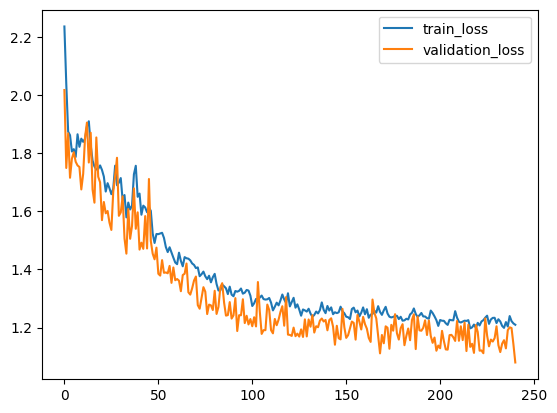

In [13]:
plt.plot(t_loss, label="train_loss")
plt.plot(v_loss, label="validation_loss")
plt.legend()
print(paramaters)

In [14]:
indice = t_loss.index(min(t_loss))
print(t_loss[indice], v_loss[indice], t_loss[indice] + v_loss[indice], indice)

1.1974024965341434 1.1337168549497922 2.3311193514839355 216


In [15]:
indice = v_loss.index(min(v_loss))
print(t_loss[indice], v_loss[indice], t_loss[indice] + v_loss[indice], indice)

1.2098281000163924 1.080046712193224 2.289874812209616 240


In [16]:
def collate_fn_eval(batch):
    images = []
    targets = []
    images_originales = []
    # Define the normalization transform
    resize = transforms.Resize(new_size, antialias=None)
    normalize = transforms.Normalize(mean=[0.53016539, 0.48067732, 0.410102], std=[0.25151319, 0.2374013, 0.23417556])
    transform = transforms.Compose([transforms.ToTensor(), resize, normalize])
    for sample in batch:
        image_original = Image.open(sample['file_name']).convert('RGB')
        width, height = image_original.size
        # Transformar la imagen
        image = transform(image_original)
        # Adaptar las anotaciones
        annotations = copy.deepcopy(sample['annotations'])
        for ann in annotations:
            bbox = ann['bbox']
            x_original, y_original, w_original, h_original = bbox
            x_new = x_original / width #* new_size[1]
            y_new = y_original / height #* new_size[0]
            w_new = w_original / width #* new_size[1]
            h_new = h_original / height #* new_size[0]
            ann['bbox'] = [x_new, y_new, w_new, h_new]
#             print(ann['bbox'])
        
        # Añadir la imagen y las anotaciones a la lista
        if len(annotations) != 0:
            images.append(image)
            images_originales.append(image_original)
            targets.append({'boxes': [ann['bbox'] for ann in annotations], 'labels': [1 for ann in annotations], "image_id": sample['image_id']})
    return images, targets, images_originales

In [17]:
DatasetCatalog.clear()
MetadataCatalog.clear()

# Registrar instancia de COCO
register_coco_instances("piscinas_test", {}, paths["annotations_test"], paths["images_test"])
# Cargar la instancia de COCO como un objeto Dataset
dataset_name = "piscinas_test"
dataset_test = DatasetCatalog.get(dataset_name)
# Obtener metadatos del dataset
metadata = MetadataCatalog.get(dataset_name)
# Declarar el DataLoader
data_loader_test = DataLoader(dataset_test, batch_size=paramaters["batch_size"], collate_fn=collate_fn_eval)

WARNING [06/29 18:58:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/29 18:58:15 d2.data.datasets.coco]: Loaded 937 images in COCO format from /tf/data/tmp/PoolsDS/Dataset improved 4/test/_annotations.coco.json


In [ ]:
model.eval()

threshold = 0.2
for n_id, (images, targets, images_originales) in enumerate(data_loader_test):
    images = [image.to(device) for image in images]
    targets = [{k: v for k, v in t.items()} for t in targets]
    output = model(images)
    for n in range(len(images)):
        image = np.asarray(images_originales[n])
#         image = np.moveaxis(image, 0, -1)
        mask_1d = output["pred_logits"][n] > threshold
        mask = torch.cat((mask_1d, mask_1d, mask_1d, mask_1d), 1)
        pred_boxes = cxcywh_to_xywh(output["pred_boxes"][n][mask].reshape(-1, 4))
        if pred_boxes.shape[0] > 0:
            fig, ax = plt.subplots()
            plt.axis('off')
            n_preds = len(pred_boxes)
            pred_boxes_xyxy = xywh_to_xyxy(pred_boxes)
            indices = torchvision.ops.nms(pred_boxes_xyxy, output["pred_logits"][n][mask_1d], 0.5) 
            pred_boxes = pred_boxes[indices]
            print("boxes", pred_boxes.shape[0], len(targets[n]["boxes"]))
            print(n_id*8+n)
            
            for bounding_box in pred_boxes:
                x, y, w, h = bounding_box.cpu().detach().numpy()
                x, y, w, h = x*new_size[0], y*new_size[1], w*new_size[0], h*new_size[1]
                bb = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor='none')
                ax.add_patch(bb)
            for bounding_box in targets[n]["boxes"]:
                x, y, w, h = bounding_box
                x, y, w, h = x*new_size[0], y*new_size[1], w*new_size[0], h*new_size[1]
                bb = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='b', facecolor='none')
                ax.add_patch(bb)
            ax.imshow(image)
            plt.show()

In [ ]:
model.eval()
images_id = [754]

threshold = 0.1
for n_id, (images, targets, images_originales) in enumerate(data_loader_test):
    images = [image.to(device) for image in images]
    targets = [{k: v for k, v in t.items()} for t in targets]
    output = model(images)
    for n in range(len(images)):
        image = np.asarray(images_originales[n])
#         image = np.moveaxis(image, 0, -1)
        mask_1d = output["pred_logits"][n] > threshold
        mask = torch.cat((mask_1d, mask_1d, mask_1d, mask_1d), 1)
        pred_boxes = cxcywh_to_xywh(output["pred_boxes"][n][mask].reshape(-1, 4))
        if pred_boxes.shape[0] > 0:
            fig, ax = plt.subplots()
            plt.axis('off')
            n_preds = len(pred_boxes)
            pred_boxes_xyxy = xywh_to_xyxy(pred_boxes)
            indices = torchvision.ops.nms(pred_boxes_xyxy, output["pred_logits"][n][mask_1d], 0.5) 
            pred_boxes = pred_boxes[indices]
            if n_id*8+n in images_id:
                print("boxes", pred_boxes.shape[0], len(targets[n]["boxes"]))
                print(n_id*8+n)

                for bounding_box in pred_boxes:
                    x, y, w, h = bounding_box.cpu().detach().numpy()
                    x, y, w, h = x*new_size[0], y*new_size[1], w*new_size[0], h*new_size[1]
                    bb = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor='none')
                    ax.add_patch(bb)
                for bounding_box in targets[n]["boxes"]:
                    x, y, w, h = bounding_box
                    x, y, w, h = x*new_size[0], y*new_size[1], w*new_size[0], h*new_size[1]
                    bb = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='b', facecolor='none')
                    ax.add_patch(bb)
                ax.imshow(image)
                plt.show()

In [16]:
DatasetCatalog.clear()
MetadataCatalog.clear()

dataset_name = "piscinas_test"
# Registrar instancia de COCO
register_coco_instances(dataset_name, {}, paths["annotations_test"], paths["images_test"])
# Cargar la instancia de COCO como un objeto Dataset
dataset = DatasetCatalog.get(dataset_name)
# Obtener metadatos del dataset
metadata = MetadataCatalog.get(dataset_name)
# Declarar el DataLoader
data_loader_test = DataLoader(dataset, batch_size=paramaters["batch_size"], collate_fn=collate_fn)

WARNING [06/29 15:56:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/29 15:56:20 d2.data.datasets.coco]: Loaded 937 images in COCO format from /tf/data/tmp/PoolsDS/Dataset improved 4/test/_annotations.coco.json


In [26]:
# DatasetCatalog.clear()
# MetadataCatalog.clear()

dataset_name = "piscinas_validation"
# Registrar instancia de COCO
register_coco_instances(dataset_name, {}, paths["annotations_validation"], paths["images_validation"])
# Cargar la instancia de COCO como un objeto Dataset
dataset = DatasetCatalog.get(dataset_name)
# Obtener metadatos del dataset
metadata = MetadataCatalog.get(dataset_name)
# Declarar el DataLoader
data_loader_validation = DataLoader(dataset, batch_size=paramaters["batch_size"], collate_fn=collate_fn)

WARNING [06/29 15:55:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/29 15:55:25 d2.data.datasets.coco]: Loaded 958 images in COCO format from /tf/data/tmp/PoolsDS/Dataset improved 4/valid/_annotations.coco.json


In [27]:
# DatasetCatalog.clear()
# MetadataCatalog.clear()

dataset_name = "piscinas_train"
# Registrar instancia de COCO
register_coco_instances(dataset_name, {}, paths["annotations_train"], paths["images_train"])
# Cargar la instancia de COCO como un objeto Dataset
dataset = DatasetCatalog.get(dataset_name)
# Obtener metadatos del dataset
metadata = MetadataCatalog.get(dataset_name)
# Declarar el DataLoader
data_loader_train = DataLoader(dataset, batch_size=paramaters["batch_size"], collate_fn=collate_fn)

WARNING [06/29 15:55:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/29 15:55:27 d2.data.datasets.coco]: Loaded 7655 images in COCO format from /tf/data/tmp/PoolsDS/Dataset improved 4/train/_annotations.coco.json


In [17]:
def bbox_iou(box1, box2):
    """
    Calcula el IoU entre dos cajas delimitadoras en formato [x1, y1, x2, y2]
    """
    # Obtener las coordenadas de la intersección
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calcular el área de la intersección
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calcular el área de ambas cajas
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calcular el IoU
    iou = inter_area / float(box1_area + box2_area - inter_area)

    return iou

def calculate_bbox_iou(dic_confusion, pred_boxes, true_boxes, threshold):
    # indice 0 predicciones
    # indice 1 true
    n_preds = pred_boxes.shape[0]
    n_true = true_boxes.shape[0]
    ious = torch.zeros(n_preds, n_true)
    for n1 in range(n_preds):
        for n2 in range(n_true):
            ious[n1, n2] = bbox_iou(pred_boxes[n1, :], true_boxes[n2, :])
    true_positives = torch.clamp(torch.sum(ious>threshold, axis=1), 0, 1).sum()
    # Calculate true_positives
    dic_confusion["true_positives"] += true_positives
    # Calculate false_positives
    dic_confusion["false_positives"] += n_preds - true_positives
    # Calculate false_negatives
    dic_confusion["false_negatives"] += n_true - torch.clamp(torch.sum(ious>threshold, axis=0), 0, 1).sum()
    
def calcular_metricas(model, data_loader, threshold_iou, threshold_preds, show_confusion=False):
    model.eval()
#     print("threshold_preds", threshold_preds, "threshold_iou", threshold_iou)
    dic_confusion = {"true_positives": 0, 
                     "false_positives": 0,
                     "false_negatives": 0}
#     for images, targets in tqdm(data_loader):
#         targets = copy.deepcopy(targets_)
    for images, targets in data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v for k, v in t.items()} for t in targets]
        output = model(images)
        for n in range(len(images)):
            pred_boxes = output["pred_boxes"][n].detach()
            mask_1d = output["pred_logits"][n]>threshold_preds
            mask = torch.cat((mask_1d, mask_1d, mask_1d, mask_1d), 1)
            pred_boxes = output["pred_boxes"][n][mask].reshape(-1, 4)
            pred_logits = output["pred_logits"][n][mask_1d]
            if pred_boxes.shape[0]>0:
                pred_boxes = cxcywh_to_xyxy(pred_boxes)
                indices = torchvision.ops.nms(pred_boxes, output["pred_logits"][n][mask_1d], 0.5) 
                pred_boxes = pred_boxes[indices]
                true_boxes = xywh_to_xyxy(torch.tensor(targets[n]["boxes"]))
                calculate_bbox_iou(dic_confusion, pred_boxes, true_boxes, threshold_iou)
            else:
                print("Error")
    if show_confusion:
        print(dic_confusion)
    
    precision = dic_confusion["true_positives"] / (dic_confusion["true_positives"] + dic_confusion["false_positives"])
    recall = dic_confusion["true_positives"] / (dic_confusion["true_positives"] + dic_confusion["false_negatives"])
    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f"{threshold_preds} & {precision:.4f} & {recall:.4f} & {f1_score:.4f} \\\\")

In [57]:
calcular_metricas(model, data_loader_test, threshold_iou = 0.5, threshold_preds = 0.4)

0.5,0.4,0.7067821025848389,0.7199411988258362,0.7133010029792786


In [16]:
calcular_metricas(model, data_loader_test, threshold_iou = 0.5, threshold_preds = 0.4)

{'true_positives': tensor(7824), 'false_positives': tensor(1029), 'false_negatives': tensor(3731)}
0.5,0.4,0.8837682008743286,0.6771094799041748,0.7667580842971802


In [24]:
calcular_metricas(model, data_loader_train, threshold_iou = 0.5, threshold_preds = 0.75)

threshold 0.5


100%|██████████| 1915/1915 [10:28<00:00,  3.05it/s]

{'true_positives': tensor(69791), 'false_positives': tensor(885), 'false_negatives': tensor(2603)}
precision tensor(0.9875)
recall tensor(0.9640)
f1_score tensor(0.9756)


In [27]:
calcular_metricas(model, data_loader_validation, threshold_iou = 0.5, threshold_preds = 0.75)

threshold 0.5


100%|██████████| 240/240 [01:18<00:00,  3.05it/s]

{'true_positives': tensor(8570), 'false_positives': tensor(118), 'false_negatives': tensor(333)}
precision tensor(0.9864)
recall tensor(0.9626)
f1_score tensor(0.9744)


In [20]:
calcular_metricas(model, data_loader_test, threshold_iou = 0.5, threshold_preds = 0.75)

{'true_positives': tensor(6710), 'false_positives': tensor(1911), 'false_negatives': tensor(3343)}
0.5,0.75,0.778331995010376,0.6674624681472778,0.7186462879180908


In [33]:
calcular_metricas(model, data_loader_test, threshold_iou = 0.5, threshold_preds = 0.7, show_confusion=True)

{'true_positives': tensor(7534), 'false_positives': tensor(934), 'false_negatives': tensor(4015)}
0.5,0.7,0.8897023797035217,0.6523508429527283,0.752760112285614


In [18]:
print("threshold_iou,threshold_preds,precision,recall,f1_score")
for x in range(1, 10):
    calcular_metricas(model, data_loader_test, threshold_iou = 0.5, threshold_preds = x/10) #241

threshold_iou,threshold_preds,precision,recall,f1_score
0.1 & 0.7820 & 0.8099 & 0.7957 \\
0.2 & 0.8415 & 0.7775 & 0.8083 \\
0.3 & 0.8701 & 0.7547 & 0.8083 \\
0.4 & 0.8885 & 0.7366 & 0.8054 \\
0.5 & 0.9008 & 0.7194 & 0.7999 \\
0.6 & 0.9121 & 0.7010 & 0.7927 \\
0.7 & 0.9237 & 0.6779 & 0.7819 \\
0.8 & 0.9334 & 0.6427 & 0.7612 \\
0.9 & 0.9505 & 0.5620 & 0.7064 \\


In [19]:
calcular_metricas(model, data_loader_test, threshold_iou = 0.5, threshold_preds = 0.1, show_confusion=True) #241

{'true_positives': tensor(9358), 'false_positives': tensor(2608), 'false_negatives': tensor(2196)}
0.1 & 0.7820 & 0.8099 & 0.7957 \\


In [25]:
print("threshold_iou,threshold_preds,precision,recall,f1_score")
for x in range(1, 10):
    calcular_metricas(model, data_loader_test, threshold_iou = 0.5, threshold_preds = x/10) # 145

threshold_iou,threshold_preds,precision,recall,f1_score
0.5,0.1,0.7152000069618225,0.7738249897956848,0.7433583736419678
0.5,0.2,0.780720055103302,0.7453034520149231,0.7626007795333862
0.5,0.3,0.8152903318405151,0.7257142663002014,0.7678987979888916
0.5,0.4,0.8389076590538025,0.7101298570632935,0.7691659331321716
0.5,0.5,0.8585329055786133,0.6952117085456848,0.7682886123657227
0.5,0.6,0.8729946613311768,0.6785002946853638,0.7635565996170044
0.5,0.7,0.8897023797035217,0.6523508429527283,0.752760112285614
0.5,0.8,0.9117533564567566,0.6146518588066101,0.7342885136604309
Error
0.5,0.9,0.9404378533363342,0.506766140460968,0.6586245894432068


In [ ]:
def calcular_metricas(model, data_loader, threshold_iou, threshold_preds, show_confusion=False):
    model.eval()
    dic_confusion = {"true_positives": 0, 
                     "false_positives": 0,
                     "false_negatives": 0}
    for images, targets in data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v for k, v in t.items()} for t in targets]
        output = model(images)
        for n in range(len(images)):
            pred_boxes = output["pred_boxes"][n].detach()
            mask_1d = output["pred_logits"][n]>threshold_preds
            mask = torch.cat((mask_1d, mask_1d, mask_1d, mask_1d), 1)
            pred_boxes = output["pred_boxes"][n][mask].reshape(-1, 4)
            pred_logits = output["pred_logits"][n][mask_1d]
            if pred_boxes.shape[0]>0:
                pred_boxes = cxcywh_to_xyxy(pred_boxes)
                indices = torchvision.ops.nms(pred_boxes, output["pred_logits"][n][mask_1d], 0.5) 
                pred_boxes = pred_boxes[indices]
                true_boxes = xywh_to_xyxy(torch.tensor(targets[n]["boxes"]))
                calculate_bbox_iou(dic_confusion, pred_boxes, true_boxes, threshold_iou)
            else:
                print("Error")
    if show:
        print(dic_confusion)
    
    roc_curve
    
    print(f"{threshold_iou},{threshold_preds},{precision},{recall},{f1_score}")